In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PeftModel
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:0"

In [3]:
## source of our data used in this project >> "https://data.mendeley.com/datasets/6k97jty9xg/5" / but the .CSV file is a preprocessed version by us
dataset = load_dataset("csv", data_files="EN-EGP.csv")
dataset = dataset["train"].train_test_split(test_size=0.1, shuffle=True, seed=42)  # Added seed for reproducibility
dataset

DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 20179
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 2243
    })
})

In [4]:
## showcasing a sapmle of the data we used
for pair in dataset['train'].select(range(5)):
    print(f"English sentence: {pair['source']}\nEgyptian Arabic translation: {pair['target']}\n")

print(f"# of translations in the dataset: {len(dataset['train'])} — relatively small for this use case, but sufficient as a base model for now.") ## only the size of the "Train" split..

English sentence: He leaves the place.
Egyptian Arabic translation: بيهرب من المكان

English sentence: You've got exams and need to study, and your dad needs to rest.
Egyptian Arabic translation: ورانا مذاكرة كتير والامتحانات خلاص قربت، ولازم بابا يريح شوية.

English sentence: I don't watch TV that much. 
Egyptian Arabic translation: انا بس مبتفرجش على التلفزيون. 

English sentence: Seriously, though. I can't believe I made it here, the camp for men only. I can't believe it.
Egyptian Arabic translation: لا لا، أنا مش مصدقة أنا إزاي أصلًا دخلت هنا، أنا مش مصدقة.

English sentence: No, no! Wait, Ola! Wait, wait! Why are you being so hasty?
Egyptian Arabic translation: لا هو ايه ما خلاص ايه بس؟ 

# of translations in the dataset: 20179 — relatively small for this use case, but sufficient as a base model for now.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/nllb-200-distilled-600M"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

SRC_LANG = "eng_Latn"
TGT_LANG = "arb_Arab"
tokenizer.src_lang = SRC_LANG

In [6]:
def translate(text, max_length=128):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    translated_tokens = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(TGT_LANG),
        max_length=max_length
    )

    return tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]

english_text = "now model all it can do is just translate to the Modern Standard Arabic version"
arabic_translation = translate(english_text)
print(arabic_translation)

الآن النموذج كل ما يمكنه فعله هو الترجمة إلى النسخة العربية المعاصرة


In [ ]:
def dataset_tokenization(batch):
    ## source language id for encoder
    model_inputs = tokenizer(
        batch["source"],  ## English translation
        max_length=128,
        padding="max_length",
        truncation=True
    )
    
    ## target language id for decoder
    # with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        batch["target"],  ## Egyptian Arabic target (desired to translate to, later)
        max_length=128,
        padding="max_length",
        truncation=True
    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(dataset_tokenization, batched=True, remove_columns=dataset["train"].column_names)
tokenized_dataset

Map: 100%|██████████| 20179/20179 [00:01<00:00, 12329.09 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20179
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2243
    })
})

In [25]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

del model
print("Loading quantized model...")
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,  ## this just uses the model_name variable defined earlier
    quantization_config=bnb_config,
    torch_dtype=torch.float16
).to(device)
print("Loaded!!")

Loading quantized model...
Loaded!!


In [ ]:
model = prepare_model_for_kbit_training(model) ## preparing out "nllb" translation model for QLoRA

## the LoRA config - Modified for better coverage and learning
lora_config = LoraConfig(
    r=8,  ## reduced rank for faster training but loss in performance is the cost here
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM ## since obviously our task is "Translation", it's set to Sequence-to-Sequence
)

model = get_peft_model(model, lora_config)
model.config.use_cache = False
model.print_trainable_parameters()

trainable params: 1,769,472 || all params: 616,843,264 || trainable%: 0.2869


In [ ]:
## now just setting up the "training" arguments + the "data collator" - Optimized for FAST training
training_args = Seq2SeqTrainingArguments(
    output_dir="./nllb-egyptian-arabic-lora-full",
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=0.5,              ## training for half an epoch (10 hours (precalculated from a simpler run))
    weight_decay=0.01,
    warmup_ratio=0.05,
    eval_strategy="steps",             ## changed it to steps-based evaluation
    eval_steps=0.1,                    ## evaluating every 10% of an epoch
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="steps",             ## saving based on steps
    save_steps=0.1,                    ## saving every 10% of an epoch
    save_total_limit=3,
    predict_with_generate=True,
    generation_max_length=128,
    fp16=True,
    push_to_hub=False,
    optim="adamw_bnb_8bit",
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={'use_reentrant': False},
    no_cuda=False,
    dataloader_num_workers=0,
    report_to="tensorboard",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,  # Crucial: Ignore padding tokens in loss calculation
    pad_to_multiple_of=8      # Pad sequences to a multiple of 8 (can improve hardware efficiency)
)
model.train()

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): M2M100ForConditionalGeneration(
      (model): M2M100Model(
        (shared): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
        (encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100SdpaAttention(
                (k_proj): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8

In [30]:
## finally initilaizing the trainingggg...
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    processing_class=tokenizer,
)

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [31]:
print("Starting training...")
trainer.train()
print("\nTraining finished successfully!")

print("\nSaving the final LoRA adapter model...")
final_save_path = os.path.join(training_args.output_dir, "final_lora_adapter")
model.save_pretrained(final_save_path)
tokenizer.save_pretrained(final_save_path)
print(f"Final LoRA adapter saved to: {final_save_path}")

Starting training...


Step,Training Loss,Validation Loss
64,12.483800,10.537194
128,9.967600,7.654379
192,8.009500,7.281080
256,7.433700,7.218786
320,7.386400,7.195452
384,7.360300,7.179754
448,7.325600,7.166705
512,7.293900,7.157198
576,7.305100,7.149240



Training finished successfully!

Saving the final LoRA adapter model...
Final LoRA adapter saved to: ./nllb-egyptian-arabic-lora-full\final_lora_adapter


## Training Loss Curve: 

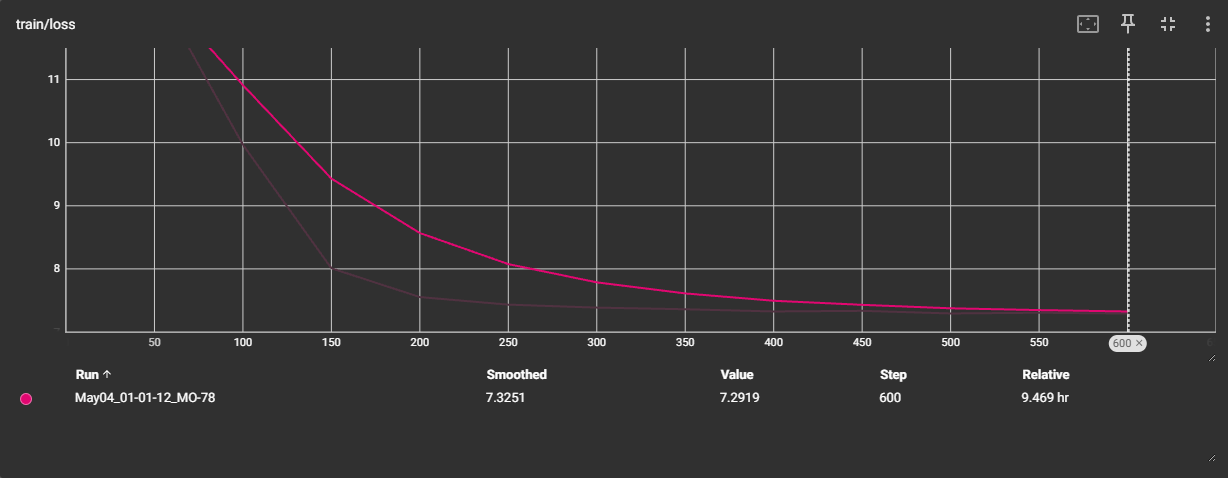

## Eval Loss Curve: 

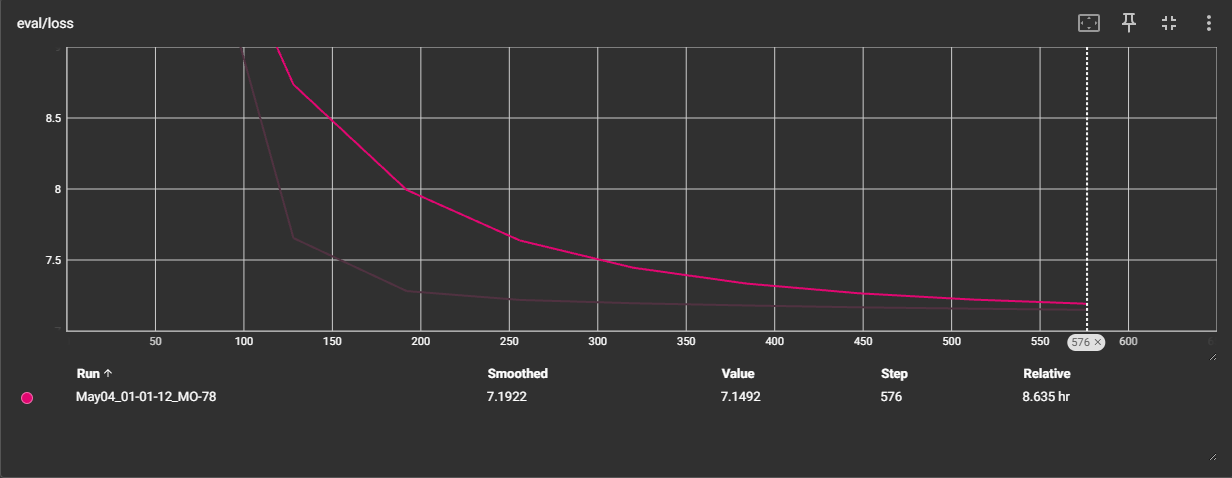

(from TensorBoard)

In [ ]:
finetuned_path = "./nllb-egyptian-arabic-lora-full/final_lora_adapter"
tokenizer = AutoTokenizer.from_pretrained(finetuned_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model_name = "facebook/nllb-200-distilled-600M"
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16
).to(device)

## here we are loading the LoRA adapter onto the base model
model = PeftModel.from_pretrained(base_model, finetuned_path).to(device)
model.eval()

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): M2M100ForConditionalGeneration(
      (model): M2M100Model(
        (shared): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
        (encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100SdpaAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_fe

In [44]:
def translate_text(text, model, tokenizer, lang):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    translated = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(lang),
        max_length=128
    )
    return tokenizer.batch_decode(translated, skip_special_tokens=True)[0]

example_texts = [
    "Good morning",
    "How are you?",
    "I want to eat",
    "Where is the market?",
    "This is delicious",
    "I don't understand",
    "What's your name?",
    "It's very hot today"
]

for text in example_texts:
    base_translation = translate_text(text, model, tokenizer, "arb_Arab")
    finetuned_translation = translate_text(text, base_model, tokenizer, "arz_Arab")
    print(f"English (base_model): {text}")
    print(f"Output (base_model): {base_translation}")
    print(f"English (finetuned_model): {text}")
    print(f"Output (finetuned_model): {finetuned_translation}")
    print("---")

English (base_model): Good morning
Output (base_model): صباح الخير
English (finetuned_model): Good morning
Output (finetuned_model): صباح الخير.
---
English (base_model): How are you?
Output (base_model): كيف حالك؟
English (finetuned_model): How are you?
Output (finetuned_model): كيف حالك؟
---
English (base_model): I want to eat
Output (base_model): أريد أن أكل
English (finetuned_model): I want to eat
Output (finetuned_model): عايز أكل.
---
English (base_model): Where is the market?
Output (base_model): أين السوق؟
English (finetuned_model): Where is the market?
Output (finetuned_model): فين السوق؟
---
English (base_model): This is delicious
Output (base_model): هذا رائع
English (finetuned_model): This is delicious
Output (finetuned_model): ده حلو جدا
---
English (base_model): I don't understand
Output (base_model): أنا لا أفهم
English (finetuned_model): I don't understand
Output (finetuned_model): أنا مش فهمت.
---
English (base_model): What's your name?
Output (base_model): اسمك؟
Engli